In [32]:
import pandas as pd
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
TEST='kendalltau'
DATA_SOURCE = 'BaselineED' #'BaselineED', 'GenBaselineED', 'GenED'
IMPUTE = False #If False Nan lines are dropped

paper_feat_columns = ["log","ratio_unique_traces_per_trace", "ratio_most_common_variant", 'ratio_top_10_variants', 'epa_normalized_variant_entropy', 'epa_normalized_sequence_entropy', 'epa_normalized_sequence_entropy_linear_forgetting', 'epa_normalized_sequence_entropy_exponential_forgetting'] 
paper_metrics_columns = ['log', 'fitness_heu', 'precision_heu',
           'fscore_heu', 'size_heu', 'cfc_heu', 'fitness_ilp', 'precision_ilp', 'fscore_ilp',
           'size_ilp','cfc_ilp', 'fitness_imf', 'precision_imf', 'fscore_imf', 'size_imf', 'cfc_imf']

In [33]:
def get_output_file_name(test, data_source, impute):    
    print(data_source)
    impute = 'imputed' if impute else 'nanDropped'
    return ("_".join([test, data_source, impute]))
print(get_output_file_name(TEST, DATA_SOURCE, IMPUTE))

BaselineED
kendalltau_BaselineED_nanDropped


In [34]:
## LOAD FEATURE AND METRICS FILES
def load_data(data_source, content):
    path = f"../data/{data_source}.csv" 
    print("Path: ", path)
    data = pd.read_csv(path).sort_values('log')
    if data_source == 'GenBaselineED_feat':
        data['log']=data.apply(lambda x: "Gen"+x['log'], axis=1)
    elif data_source == 'GenBaselineED_bench':
            data['log']=data.apply(lambda x: "Gen"+x['log'].replace("genEL","").rsplit("_",7)[0], axis=1)
    return data

In [35]:
### INSTANCE SELECTION: NULLS OR IMPUTATION?
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

def clean_data(fd_pdm, impute=False, feat_columns=paper_feat_columns, metric_columns=paper_metrics_columns):
    num_cols = fd_pdm.convert_dtypes().select_dtypes(exclude=['string']).columns
    str_cols = fd_pdm.convert_dtypes().select_dtypes(include=['string']).columns

    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit(fd_pdm.drop(str_cols, axis=1))
    imp_df = imputer.transform(fd_pdm.drop(str_cols, axis=1))
    imp_df = pd.DataFrame(imp_df, columns=num_cols)
    imp_df['log'] = fd_pdm['log']
    print("Imputed dataset:" ,imp_df.shape)

    ft_pdm_no_nans = fd_pdm.copy()
    ft_pdm_no_nans = ft_pdm_no_nans.dropna()
    ft_pdm_no_nans['log'] = fd_pdm['log']
    print("No nan's dataset:" ,ft_pdm_no_nans.shape)
    #print(len(ft_pdm_no_nans[ft_pdm_no_nans['source']==DATA_SOURCE]['log']))
    print("FT_COL: ", feat_columns)
    print("M_COL: ", metric_columns)
    
    if IMPUTE:
        benchmarked_ft = imp_df[feat_columns]
        benchmarked_pd = imp_df[metric_columns]
    else:
        benchmarked_ft = ft_pdm_no_nans[feat_columns]
        benchmarked_pd = ft_pdm_no_nans[metric_columns]
    return benchmarked_ft, benchmarked_pd

Path:  ../data/BaselineED_feat.csv
(26, 8)
['BPIC12', 'BPIC13cp', 'BPIC13inc', 'BPIC13op', 'BPIC14dc_p', 'BPIC14di_p', 'BPIC14dia_p', 'BPIC15f1', 'BPIC15f2', 'BPIC15f3', 'BPIC15f4', 'BPIC15f5', 'BPIC16c_p', 'BPIC16wm_p', 'BPIC17', 'BPIC17ol', 'BPIC19', 'BPIC20a', 'BPIC20b', 'BPIC20c', 'BPIC20d', 'BPIC20e', 'HD', 'RTFMP', 'RWABOCSL', 'SEPSIS']
Path:  ../data/BaselineED_bench.csv
(17, 19)
['BPIC13cp', 'BPIC13inc', 'BPIC13op', 'BPIC14dc_p', 'BPIC14di_p', 'BPIC16c_p', 'BPIC16wm_p', 'BPIC17ol', 'BPIC20a', 'BPIC20b', 'BPIC20c', 'BPIC20d', 'BPIC20e', 'HD', 'RTFMP', 'RWABOCSL', 'SEPSIS']
(17, 26)
Index(['log', 'ratio_unique_traces_per_trace', 'ratio_most_common_variant',
       'ratio_top_10_variants', 'epa_normalized_variant_entropy',
       'epa_normalized_sequence_entropy',
       'epa_normalized_sequence_entropy_linear_forgetting',
       'epa_normalized_sequence_entropy_exponential_forgetting', 'fitness_heu',
       'precision_heu', 'fscore_heu', 'size_heu', 'pnsize_heu', 'cfc_heu',
     

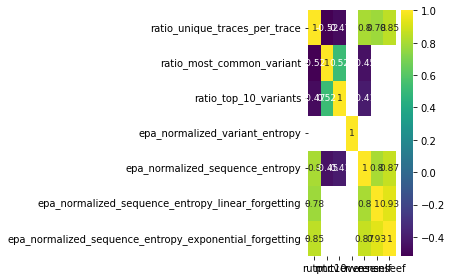

In [39]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import pearsonr
from numpy import isnan

import sys
import os
sys.path.append(os.path.dirname("../gedi/utils/io_helpers.py"))
from io_helpers import get_keys_abbreviation

def statistical_test(feature_source, bench_source, test, impute=False):
    ft = load_data(feature_source, 'feat')
    #paper_feat_columns = ["log","ratio_unique_traces_per_trace", "ratio_most_common_variant", 'ratio_top_10_variants', 'epa_normalized_variant_entropy', 'epa_normalized_sequence_entropy', 'epa_normalized_sequence_entropy_linear_forgetting', 'epa_normalized_sequence_entropy_exponential_forgetting'] 
    #ft= ft[paper_feat_columns]
    print(ft.shape)
    print(ft['log'].tolist())


    ben = load_data(bench_source, 'bench')
    #ben['log']=ben.apply(lambda x: x['log'].replace("Gen",""), axis=1)
    '''
    paper_metrics_columns = ['log', 'fitness_heu', 'precision_heu',
           'fscore_heu', 'size_heu', 'cfc_heu', 'fitness_ilp', 'precision_ilp', 'fscore_ilp',
           'size_ilp','cfc_ilp', 'fitness_imf', 'precision_imf', 'fscore_imf', 'size_imf', 'cfc_imf']
    '''
    #ben = ben[paper_metrics_columns]
    print(ben.shape)
    print(ben['log'].tolist())
    fd_pdm = pd.merge(ft, ben, on=['log'], how='inner').reset_index(drop=True)#.reindex(both_df.index)

    ## DROP DUPLICATES
    fd_pdm = fd_pdm.reset_index(drop=True)
    fd_pdm = fd_pdm.T.drop_duplicates().T
    print(fd_pdm.shape)
    fd_pdm['log'].unique()
    
    print(fd_pdm.columns)
    benchmark_ft, benchmark_pd = clean_data(fd_pdm, impute, paper_feat_columns, paper_feat_columns)
    
    print(benchmark_ft.shape, benchmark_pd.shape)

    benchmarked_ft_plot = benchmark_ft.copy()
    benchmarked_pdm_plot = benchmark_pd.copy()

    #benchmarked_ft = benchmarked_ft.head(10)
    #benchmarked_pdm = benchmarked_pdm.head(10)
    print(DATA_SOURCE, benchmarked_ft_plot.shape, benchmarked_pdm_plot.shape)

    tmp = list(benchmarked_ft_plot.columns[1:-1])
    df_tmp = pd.DataFrame(index=benchmarked_pdm_plot.columns[1:-1], columns=tmp)
    #print("Benchmark_pdm:", benchmarked_pdm.columns[1:-1])
    #print ("Benchmark_ft:", tmp)

    for feature in benchmarked_ft_plot.columns:
        if feature != 'log' and feature != 'source':
            for metric in benchmarked_pdm_plot.columns:
                if metric != 'log' and metric != 'source':
                    #print(feature, benchmarked_pdm.columns[1])
                    stat, p = eval(f"{TEST}(benchmarked_ft_plot[feature], benchmarked_pdm_plot[metric])")   
                    #print(feature, metric, p, p <= 0.05)
                    df_tmp.loc[metric, feature] = stat*(1.0 if (p <= 0.05) else 0.0)

    feature_keys = get_keys_abbreviation(df_tmp.columns).split("_")
    print(feature_keys)
    df_tmp.columns=feature_keys
    print("Direct", TEST, DATA_SOURCE)
    # df_tmp[pd.isnan()]

    sns.heatmap(df_tmp.fillna(0), annot=True, cmap="viridis", annot_kws={"size": 9})
    ax = plt.gca()
    sns.heatmap(df_tmp.fillna(0), mask=df_tmp.fillna(0)!=0, cmap="Greys", annot=False, cbar=False, ax=ax)
    #ax.set_title("P-values of features leading to process discovery metrics", fontsize=15)
    plt.tight_layout()
    output_path = f"../output/plots/pdm_{get_output_file_name(TEST, DATA_SOURCE, IMPUTE)}"
    print(output_path)
    plt.savefig(output_path, dpi=300)

statistical_test(DATA_SOURCE+"_feat", DATA_SOURCE+"_bench", TEST, IMPUTE)

## Statistical test: Is there a statistical significant relation between feature similarity and performance metrics?

In [ ]:
### DIRECT STATISTICAL TEST
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import pearsonr
from numpy import isnan

import sys
import os
sys.path.append(os.path.dirname("../gedi/utils/io_helpers.py"))
from io_helpers import get_keys_abbreviation

